In [2]:
from environment import EnvironmentGoogleSnake
from torch import nn
import torch

from torchvision.transforms import ToTensor

import gymnasium as gym
import numpy as np

import matplotlib.pyplot as plt
import copy


from torchinfo import summary

In [3]:
class PreProcessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env=env)

    def reset(self):
        obs = self.env.reset()
        return ToTensor()(obs).unsqueeze(dim = 0).float()
    
    def step(self, action: torch.Tensor):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = ToTensor()(next_state).unsqueeze(dim = 0)
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info
    

In [6]:
# env = EnvironmentGoogleSnake()
# env = PreProcessEnv(env)
from maze import Maze

# Constants
GAME_HEIGHT = 600
GAME_WIDTH = 600
NUMBER_OF_TILES = 25
SCREEN_HEIGHT = 700
SCREEN_WIDTH = 700
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXXXXXXXXXXXXXX",
    "X XXXXXXXX          XXXXX",
    "X XXXXXXXX  XXXXXX  XXXXX",
    "XP     XXX  XXXXXX  XXXXX",
    "X      XXX  XXX         X",
    "XXXXXX  XX  XXX        XX",
    "XXXXXX  XX  XXXXXX  XXXXX",
    "XXXXXX  XX  XXXXXX  XXXXX",
    "X  XXX      XXXXXXXXXXXXX",
    "X  XXX  XXXXXXXXXXXXXXXXX",
    "X         XXXXXXXXXXXXXXX",
    "X             XXXXXXXXXXX",
    "XXXXXXXXXXX      XXXXX  X",
    "XXXXXXXXXXXXXXX  XXXXX  X",
    "XXX  XXXXXXXXXX         X",
    "XXX                     X",
    "XXX         XXXXXXXXXXXXX",
    "XXXXXXXXXX  XXXXXXXXXXXXX",
    "XXXXXXXXXX              X",
    "XX   XXXXX              X",
    "XX   XXXXXXXXXXXXX  XXXXX",
    "XX    XXXXXXXXXXXX  XXXXX",
    "XX        XXXX          X",
    "XXXX                    X",
    "XXXXXXXXXXXXXXXXXXXXXXXXX",
]

env = Maze(
    level,
    goal_pos=(23, 20),
    MAZE_HEIGHT=GAME_HEIGHT,
    MAZE_WIDTH=GAME_WIDTH,
    SIZE=NUMBER_OF_TILES,
)
env = PreProcessEnv(env)
NO_OF_ACTIONS = 4

# env.unwrapped.start()
# state = env.reset()

next_state, reward, done, info = env.step(torch.tensor(2))

print(f"Next State: {next_state}, Reward: {reward}, Done: {done}, Info: {info}")

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

In [5]:
next_state.squeeze(axis = 0).shape

AttributeError: 'tuple' object has no attribute 'squeeze'

(-0.5, 127.5, 127.5, -0.5)

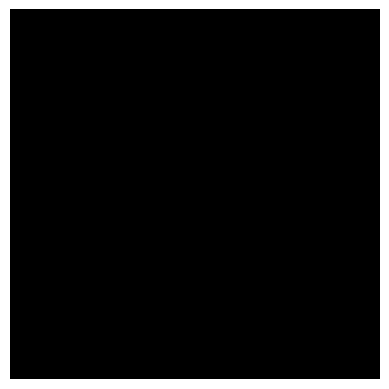

In [ ]:
plt.imshow(next_state.squeeze(), cmap="gray")
plt.axis("off")

In [ ]:
class DeepRLModel(torch.nn.Module):

    def __init__(self, in_channels, hidden_units, out_channels):
        super().__init__()
        self.conv_block_1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = in_channels, out_channels = hidden_units, kernel_size = 3, padding = 1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size =3, padding = 1 ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features = 20480, out_features = out_channels),
            torch.nn.Softmax(dim = 1)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
q_network = DeepRLModel(1, 20, 4).to(device)
summary(q_network, (3, 1,  128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
DeepRLModel                              [3, 4]                    --
├─Sequential: 1-1                        [3, 20, 64, 64]           --
│    └─Conv2d: 2-1                       [3, 20, 128, 128]         200
│    └─ReLU: 2-2                         [3, 20, 128, 128]         --
│    └─Conv2d: 2-3                       [3, 20, 128, 128]         3,620
│    └─ReLU: 2-4                         [3, 20, 128, 128]         --
│    └─MaxPool2d: 2-5                    [3, 20, 64, 64]           --
├─Sequential: 1-2                        [3, 20, 32, 32]           --
│    └─Conv2d: 2-6                       [3, 20, 64, 64]           3,620
│    └─ReLU: 2-7                         [3, 20, 64, 64]           --
│    └─Conv2d: 2-8                       [3, 20, 64, 64]           3,620
│    └─ReLU: 2-9                         [3, 20, 64, 64]           --
│    └─MaxPool2d: 2-10                   [3, 20, 32, 32]           --
├─Seq

In [ ]:
target_q_network = copy.deepcopy(q_network).to(device)
target_q_network.eval()

DeepRLModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20480, out_features=4, bias=True)
    (2): Softmax(dim=1)
  )
)

In [ ]:
q_network(next_state.to(device)).gather(1, torch.tensor([[1]]).to(device))

tensor([[0.2461]], device='cuda:0', grad_fn=<GatherBackward0>)

In [ ]:
def policy(state, epsilon = 0.05):
    if torch.rand(1) < epsilon:
        return torch.randint(4, (1, 1))
    else:
        av = q_network(state.to(device))
        return torch.argmax(av, dim = -1, keepdim = True)

In [ ]:
from torch.optim import AdamW
from memory import ReplayMemory
from tqdm import tqdm
import torch.nn.functional as F

def deep_sarsa(q_network:DeepRLModel, policy, episodes, alpha=0.004, batch_size=32, gamma=0.99, epsilon=0.03):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory(capacity = 1000000)
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.to(device)
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)

                state_b = state_b.to(device)
                reward_b = reward_b.to(device)
                done_b = done_b.to(device)
                next_state_b = next_state_b.to(device)
                action_b = action_b.to(device)
                          
                qsa_b = q_network(state_b).gather(1, action_b).to(device)

                next_action_b = policy(next_state_b).to(device)
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b).to(device)
                target_b = reward_b + ~done_b * gamma * next_qsa_b

                
                loss = F.mse_loss(qsa_b, target_b.to(device))
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                loss.item()
                stats['MSE Loss'].append(loss.item())
            
            state = next_state
            ep_return += reward.item()
        
        stats['Returns'].append(ep_return)
        print(stats['Returns'])
        if episode % 100 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
        
    return stats

In [ ]:
deep_sarsa(q_network, policy, episodes = 1000)

  0%|          | 1/1000 [00:04<1:10:34,  4.24s/it]

[-1.0]


  0%|          | 2/1000 [00:10<1:34:29,  5.68s/it]

[-1.0, 0.0]


  0%|          | 3/1000 [00:15<1:26:39,  5.22s/it]

[-1.0, 0.0, -1.0]


  0%|          | 4/1000 [00:20<1:24:38,  5.10s/it]

[-1.0, 0.0, -1.0, 0.0]


  0%|          | 5/1000 [00:24<1:15:21,  4.54s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0]


  1%|          | 6/1000 [00:28<1:16:04,  4.59s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0]


  1%|          | 7/1000 [00:33<1:14:13,  4.48s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0]


  1%|          | 8/1000 [00:36<1:10:49,  4.28s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0]


  1%|          | 9/1000 [00:42<1:15:36,  4.58s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  1%|          | 10/1000 [00:47<1:18:49,  4.78s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]


  1%|          | 11/1000 [00:50<1:12:42,  4.41s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0]


  1%|          | 12/1000 [00:56<1:17:15,  4.69s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0]


  1%|▏         | 13/1000 [01:00<1:14:42,  4.54s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0]


  1%|▏         | 14/1000 [01:04<1:10:22,  4.28s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  2%|▏         | 15/1000 [01:07<1:06:54,  4.08s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]


  2%|▏         | 16/1000 [01:11<1:06:02,  4.03s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 17/1000 [01:16<1:11:37,  4.37s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 18/1000 [01:20<1:10:14,  4.29s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 19/1000 [01:24<1:07:21,  4.12s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 20/1000 [01:30<1:13:37,  4.51s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 21/1000 [01:33<1:08:58,  4.23s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 22/1000 [01:37<1:05:32,  4.02s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 23/1000 [01:40<1:03:20,  3.89s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▏         | 24/1000 [01:44<1:01:47,  3.80s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  2%|▎         | 25/1000 [01:49<1:08:00,  4.19s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  3%|▎         | 26/1000 [01:53<1:09:38,  4.29s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]


  3%|▎         | 27/1000 [01:58<1:13:15,  4.52s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0]


  3%|▎         | 28/1000 [02:02<1:08:24,  4.22s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  3%|▎         | 29/1000 [02:06<1:08:36,  4.24s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0]


  3%|▎         | 30/1000 [02:12<1:14:35,  4.61s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0]


  3%|▎         | 31/1000 [02:15<1:08:26,  4.24s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  3%|▎         | 32/1000 [02:21<1:14:50,  4.64s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]


  3%|▎         | 33/1000 [02:24<1:09:30,  4.31s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0]


  3%|▎         | 34/1000 [02:28<1:05:54,  4.09s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  4%|▎         | 35/1000 [02:33<1:13:10,  4.55s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  4%|▎         | 36/1000 [02:38<1:12:57,  4.54s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]


  4%|▎         | 37/1000 [02:43<1:17:19,  4.82s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0]


  4%|▍         | 38/1000 [02:47<1:12:29,  4.52s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  4%|▍         | 39/1000 [02:51<1:10:03,  4.37s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]


  4%|▍         | 40/1000 [02:55<1:07:36,  4.23s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0]


  4%|▍         | 41/1000 [02:59<1:04:27,  4.03s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  4%|▍         | 42/1000 [03:03<1:06:43,  4.18s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  4%|▍         | 43/1000 [03:08<1:07:38,  4.24s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  4%|▍         | 44/1000 [03:11<1:05:06,  4.09s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0]


  4%|▍         | 45/1000 [03:16<1:07:50,  4.26s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0]


  5%|▍         | 46/1000 [03:23<1:18:05,  4.91s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0]


  5%|▍         | 47/1000 [03:27<1:14:47,  4.71s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0]


  5%|▍         | 48/1000 [03:32<1:19:38,  5.02s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0]


  5%|▍         | 49/1000 [03:36<1:12:48,  4.59s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  5%|▌         | 50/1000 [03:40<1:11:10,  4.50s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]


  5%|▌         | 51/1000 [03:44<1:06:44,  4.22s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0]


  5%|▌         | 52/1000 [03:48<1:03:39,  4.03s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  5%|▌         | 53/1000 [03:53<1:09:14,  4.39s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  5%|▌         | 54/1000 [03:56<1:05:51,  4.18s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  6%|▌         | 55/1000 [04:01<1:06:37,  4.23s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]


  6%|▌         | 56/1000 [04:05<1:05:27,  4.16s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0]


  6%|▌         | 57/1000 [04:08<1:02:46,  3.99s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  6%|▌         | 58/1000 [04:12<1:00:46,  3.87s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]


  6%|▌         | 59/1000 [04:16<59:22,  3.79s/it]  

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0]


  6%|▌         | 60/1000 [04:19<58:14,  3.72s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  6%|▌         | 61/1000 [04:24<1:02:56,  4.02s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  6%|▌         | 62/1000 [04:28<1:03:54,  4.09s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  6%|▋         | 63/1000 [04:32<1:04:26,  4.13s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  6%|▋         | 64/1000 [04:37<1:05:48,  4.22s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]


  6%|▋         | 65/1000 [04:41<1:07:24,  4.33s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0]


  7%|▋         | 66/1000 [04:46<1:07:47,  4.35s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0]


  7%|▋         | 67/1000 [04:49<1:04:07,  4.12s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0]


  7%|▋         | 68/1000 [04:54<1:04:37,  4.16s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0]


  7%|▋         | 69/1000 [04:59<1:10:47,  4.56s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0]


  7%|▋         | 70/1000 [05:04<1:13:10,  4.72s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0]


  7%|▋         | 71/1000 [05:08<1:07:39,  4.37s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]


  7%|▋         | 72/1000 [05:11<1:03:50,  4.13s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0]


  7%|▋         | 73/1000 [05:15<1:01:44,  4.00s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  7%|▋         | 74/1000 [05:19<1:02:22,  4.04s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  8%|▊         | 75/1000 [05:24<1:04:42,  4.20s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  8%|▊         | 76/1000 [05:27<1:01:48,  4.01s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  8%|▊         | 77/1000 [05:31<1:00:20,  3.92s/it]

[-1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


  8%|▊         | 77/1000 [05:34<1:06:51,  4.35s/it]


NoSuchWindowException: Message: Browsing context has been discarded
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:189:5
NoSuchWindowError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:630:5
assert.that/<@chrome://remote/content/shared/webdriver/Assert.sys.mjs:485:13
assert.open@chrome://remote/content/shared/webdriver/Assert.sys.mjs:147:4
GeckoDriver.prototype.findElement@chrome://remote/content/marionette/driver.sys.mjs:1497:15
despatch@chrome://remote/content/marionette/server.sys.mjs:318:40
execute@chrome://remote/content/marionette/server.sys.mjs:289:16
onPacket/<@chrome://remote/content/marionette/server.sys.mjs:262:20
onPacket@chrome://remote/content/marionette/server.sys.mjs:263:9
_onJSONObjectReady/<@chrome://remote/content/marionette/transport.sys.mjs:494:20
observe@resource://gre/modules/AsyncShutdown.sys.mjs:573:17
